In [1]:
import numpy as np
import warnings 
from sklearn.model_selection import train_test_split
import scipy as scio
from scipy.spatial.distance import pdist
from scipy.linalg import cho_factor, cho_solve, cholesky
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import mean_squared_error
from sklearn.utils import check_array, check_random_state
from sklearn.linear_model.ridge import _solve_cholesky_kernel as kernel_solve
from time import time

%matplotlib inline
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

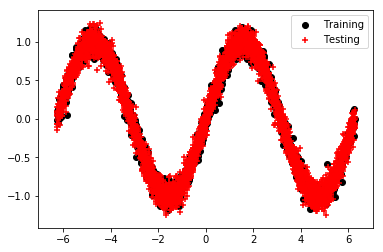

(10000, 1) (10000, 1)
(40000, 1) (40000, 1)


In [2]:
# generate datasets
random_state = 123
num_points = 50000

x_data = np.linspace(-2*np.pi, 2*np.pi, num=num_points)
y_data = np.sin(x_data)

# add some noise
generator = check_random_state(random_state)
y_data += 0.1 * generator.randn(num_points)

# convert to 2D, float array for scikit-learn input
x_data = x_data[:, np.newaxis].astype(np.float)
y_data = y_data[:, np.newaxis].astype(np.float)


# split data into training and testing
train_percent = 0.2

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, train_size=train_percent,
    random_state=random_state
)

# plot the training data
fig, ax = plt.subplots()

ax.scatter(x_train[::10], y_train[::10], color='k', label='Training')
ax.scatter(x_test[::10], y_test[::10], color='r', marker='+', label='Testing')

ax.legend()
plt.show()

# remove the mean from the training data
y_mean = np.mean(y_train)

y_train -= y_mean
y_test -= y_mean

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

In [3]:
# parameter heuristics
mean_sigma = np.mean(pdist(x_train, metric='euclidean'))
lam = 1e-04

mean_gamma = 1 / (2 * mean_sigma ** 2)

# construct kernel matrices
K_train = rbf_kernel(X=x_train, gamma=mean_gamma)

### Different Solvers

In [4]:
# cholesky decomposition: with functions
t0 = time()
R, lower = cho_factor(K_train + lam * np.eye(x_train.shape[0]))
weights = cho_solve((R, lower), y_train)
t1 = time() - t0
print('\nTime taken for cholesky with functions: {:.4f} secs\n'.format(t1))


Time taken for cholesky with functions: 6.4920 secs



#### Are they the same?

### Predictions (Batch)

In [6]:
# split testing data (K-fold)
n_samples, n_dimensions = x_test.shape
n_samples_per_batch = 1000
n_batches = int(np.round(n_samples / n_samples_per_batch))

print("Number of Test samples: ", n_samples)
print("Number of samples per batch: ", n_samples_per_batch)
print("Number of batches: {}".format(n_batches))

Number of Test samples:  40000
Number of samples per batch:  1000
Number of batches: 40


Serial Processing time: 6.15268 secs


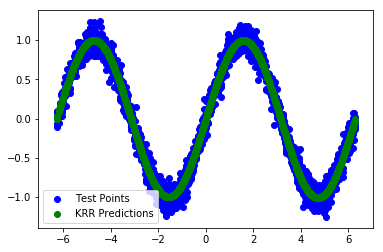

In [7]:
BatchIterator = KFold(n_splits=n_batches)

# predefine matrices
y_pred = np.empty(y_test.shape)
variance = np.empty(y_test.shape) 

# calculate the inverse matrix
K_train_inv = np.linalg.inv(K_train)

start_time = time()

for (ibatch, (_, ibatch_index)) in enumerate(BatchIterator.split(x_test)):
    
    
    # calculate the train-test kernel
    K_traintest = rbf_kernel(x_train, x_test[ibatch_index], 
                             gamma=mean_gamma)
    
    # calculate the predictions
    y_pred[ibatch_index] = K_traintest.T @ weights
        
end_time = time() - start_time
print('Serial Processing time: {:.5f} secs'.format(end_time))

fig, ax = plt.subplots()

ax.scatter(x_test[::20], y_test[::20], color='b', label='Test Points')
ax.scatter(x_test[::20], y_pred[::20], color='g', label='KRR Predictions')


ax.legend()
plt.show()

### Batch Predictions in Parallel

In [9]:
import multiprocessing as mp

def calculate_predictions(x_train, x_test, indices, weights, gamma):
    
    # calculate train-test kernel
    K_traintest = rbf_kernel(x_train, x_test[indices, :],
                             gamma=gamma)
    
    # calculate the predictions
    return K_traintest.T @ weights

def calculate_variance(x_train, x_test, indices, 
                       K_traintest, K_train_inverse, gamma):
    
    
    K_batch = rbf_kernel(x_test[indices, :], gamma=gamma)
    
    variance = np.diag(K_batch) - np.diag(K_traintest.T @
                                          K_traininverse @
                                          K_traintest)
    
    return variance

def krr_batch_prediction_multi(x_train, x_test, weights, gamma,
                               n_batches=None, n_jobs=1, 
                               calculate_variance=False):
    
    # check for num of proc vs n_jobs selected
    num_procs = mp.cpu_count()
    
    if num_procs < n_jobs:
        Pool = mp.Pool(processes=n_jobs)
    else:
        Pool = mp.Pool(processes=num_procs)
    
    # get dimensions of the data
    n_samples, n_dimensions = x_test.shape

    # default batch number
    if n_batches is None:
        n_batches = int(np.round(n_samples / 500))

    variance = None

    # check variance
    if calculate_variance is True:
        K_train = rbf_kernel(x_train, gamma=gamma)
        K_train_inverse = np.linalg.inv(K_train)
        variance = np.empty(shape=(n_samples, 1))
        
    # create a batch iterator generator
    BatchIterator = KFold(n_splits=n_batches)
    
    # predefine matrices 
    y_pred = np.empty(shape=(n_samples, 1))
    
    pred_pool = \
        [Pool.apply(calculate_predictions, args=(
            x_train, x_test, indices, weights, gamma)) 
         for _, indices in BatchIterator.split(x_test)]
        
    # get pooled results
    for i, (_, indices) in enumerate(BatchIterator.split(x_test)):
        y_pred[indices] = pred_pool[i]
        
        
    # Calculate Variance
    if calculate_variance is True:
        
        # calculate train-test kernel
        K_traintest = rbf_kernel(x_train, x_test,
                                 gamma=gamma)
        # 
        var_pool = \
            [Pool.apply(calculate_variance, args=(
                x_train, x_test, indices, K_traintest, 
                K_train_inverse, gamma)) 
             for _, indices in BatchIterator.split(x_test)]
            
        # get pooled results
        for i, (_, indices) in enumerate(BatchIterator.split(x_test)):
            variance[indices] = var_pool[i]
            
    return y_pred, variance
        
    
    

MultiProcess Pools time: 6.20904 secs
True


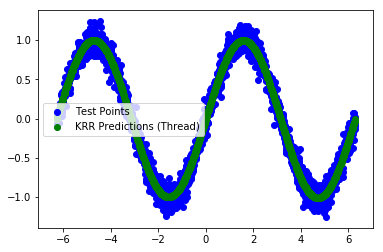

In [12]:


start_time = time()

threads = []

num_process = mp.cpu_count()

Pool = mp.Pool(processes=num_process-2)
# distribute results in multiprocessing
y_pred_mp = np.empty(y_test.shape)

results_pool = \
    [Pool.apply(calculate_predictions, args=(
    x_train, x_test, indices, weights, mean_gamma)) 
           for _, indices in BatchIterator.split(x_test)]



# reshape array
for i, (_, indices) in enumerate(BatchIterator.split(x_test)):

    y_pred_mp[indices] = results_pool[i]

end_time = time() - start_time
print('MultiProcess Pools time: {:.5f} secs'.format(end_time))
print(np.allclose(y_pred, y_pred_mp))

# PLOT RESULTS
fig, ax = plt.subplots()

ax.scatter(x_test[::20], y_test[::20], color='b', label='Test Points')
ax.scatter(x_test[::20], y_pred_mp[::20], color='g', label='KRR Predictions (Thread)')


ax.legend()
plt.show()

In [ ]:
# The original batch function

for (ibatch, (_, ibatch_index)) in enumerate(BatchIterator.split(x_test)):
    
    # calculate the train-test kernel
    K_traintest = rbf_kernel(x_train, x_test[ibatch_index], 
                             gamma=mean_gamma)
    
    # calculate the predictions
    y_pred[ibatch_index] = K_traintest.T @ weights

In [62]:
# Modified
# Create Batch Iterator Object
BatchIterator = KFold(n_splits=n_batches)

batch_list = []

for _, ibatch in BatchIterator.split(x_test):
    batch_list.append(ibatch)

for ibatch_index in batch_list:
    
    # calculate the train-test kernel
    K_traintest = rbf_kernel(x_train, x_test[ibatch_index, :], 
                             gamma=mean_gamma)
    
    # calculate the predictions
    y_pred[ibatch_index] = K_traintest.T @ weights
    


#### Multiprocessing (Pool Function)

#### Threading

In [108]:
import threading

start_time = time()

threads = []
# initialize thread
threads = [threading.Thread(target=calculate_predictions, args=(
    x_train, x_test, indices, weights, mean_gamma)) 
           for _, indices in BatchIterator.split(x_test)]

# start threads
resuts = [thread.start for thread in threads]

# join results to one thread
results = [thread.join for thread in threads]

end_time = time() - start_time
print('Threads time: {:.5f} secs'.format(end_time))

# concatentate results
y_pred_thread = np.empty(y_test.shape)

for i , indices in enumerate(BatchIterator.split(x_test)):
    y_pred_thread[indices] = results[i]


# PLOT RESULTS
fig, ax = plt.subplots()

ax.scatter(x_test, y_test, color='b', label='Test Points')
ax.scatter(x_test, y_pred_thread, color='g', label='KRR Predictions (Thread)')


ax.legend()
plt.show()

Threads time: 0.00175 secs
<bound method Thread.join of <Thread(Thread-381, initial)>>


TypeError: float() argument must be a string or a number, not 'method'

#### Muiltiprocessing Module

In [61]:
# Simplier
def calculate_predictions(ibatch, batch_indices, x_train, x_test, weights, gamma):
    
    test_indices = batch_indices[ibatch]
    
    K = rbf_kernel(x_train, x_test[test_indices], gamma)
    predictions = K.T @ weights
    return predictions

### Serial

In [67]:
import os
import threading


In [69]:
import threading
n_batches = 20
print('Number of batches: {}'.format(n_batches))

# Create Batch Iterator Object
BatchIterator = KFold(n_splits=n_batches)

batch_list = []

for _, ibatch in BatchIterator.split(x_train):
    batch_list.append(ibatch)

# predefine matrices
y_pred = np.empty(y_test.shape)
variance = np.empty(y_test.shape) 

# calculate the inverse matrix
K_train_inv = np.linalg.inv(K_train)

Number of batches: 20


In [ ]:
fig, ax = plt.subplots()

ax.scatter(x_test, y_test, color='b', label='Test Points')
ax.scatter(x_test, y_pred_serial, color='g', label='KRR Predictions (Serial)')


ax.legend()
plt.show()

### Simple Calculation

In [26]:
def calculate_predictions(ibatch, batch_indices, x_train, x_test, weights, gamma):
    
    test_indices = batch_indices[ibatch]
    
    K = rbf_kernel(x_train, x_test[test_indices], gamma)
    predictions = K.T @ weights
    return predictions

### Serial Code

In [27]:
# serial implementation
start_time = time()

print('Shape of x_data: {}'.format(x_test.shape))
y_pred_serial = np.empty(y_test.shape)


results_serial = []
for ibatch in range(len(batch_list)):
    results_serial.append(calculate_predictions(ibatch,
                                         batch_list,
                                         x_train,
                                         x_train,
                                         weights,
                                         mean_gamma))
    
end_time = time() - start_time
print('Serial Time: {:.4f} secs'.format(end_time))
print(len(results_serial))

# concatentate results
for i in results_serial:
    y_pred_serial[batch_list[ibatch]] = i

print('Shape of y_data: {}'.format(y_pred_serial.shape))

Shape of x_data: (600, 1)
Serial Time: 0.0084 secs
20
Shape of y_data: (600, 1)


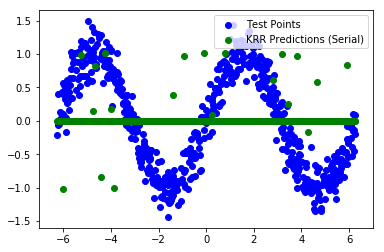

In [28]:
fig, ax = plt.subplots()

ax.scatter(x_test, y_test, color='b', label='Test Points')
ax.scatter(x_test, y_pred_serial, color='g', label='KRR Predictions (Serial)')


ax.legend()
plt.show()

In [ ]:
import multiprocessing as mp

In [ ]:
# define output queue
output = mp.Queue



In [ ]:
#Preliminary Stuff






for _, ibatch in BatchIterator.split(x_train):
    
    K = rbf_kernel(x_train, x_test[ibatch], mean_gamma)


### Threads

In [ ]:
import os
import threading
import multiprocessing

In [ ]:
num_workers = 2

def calculate_predictions(ibatch, batch_indices, x_train, x_test, weights, gamma):
    
    print("PID: %s, Process Name: %s, Thread Name: %s" % (
        os.getpid(),
        multiprocessing.current_process().name,
        threading.current_thread().name)
    )
    
    test_indices = batch_indices[ibatch]
    
    K = rbf_kernel(x_train, x_test[test_indices], gamma)
    predictions = K.T @ weights
    
    return predictions


In [ ]:
start_time = time()

threads = []
# initialize thread
threads = [threading.Thread(target=calculate_predictions, args=(
    ibatch, batch_list, x_train, x_test, weights, mean_gamma)) 
           for ibatch in range(len(batch_list))]

# start threads
resuts = [thread.start for thread in threads]

# join results to one thread
results = [thread.join for thread in threads]

end_time = time() - start_time
print('Threads time: {:.5f} secs'.format(end_time))

In [ ]:
print(len(threads))
print(results)

In [ ]:
start_time = time()

Pool = mp.Pool(processes=1)
print('Shape of x_data: {}'.format(x_test.shape))
y_pred_mp = np.empty(y_test.shape)

# distribute results in multiprocessing
results_pools = []

results_pools = \
    [Pool.apply(calculate_predictions,
                args=(ibatch, 
                      batch_list, 
                      x_train, 
                      x_test, 
                      weights, 
                      mean_gamma)) 
           for ibatch in range(len(batch_list))]

end_time = time() - start_time
print('Serial Time: {:.4f} secs'.format(end_time))

# concatentate results
for i in results_pools:
    y_pred_mp[batch_list[ibatch]] = i

print('Shape of y_data: {}'.format(y_pred_mp.shape))

In [ ]:
# are they the same?
print(np.allclose(y_pred_mp, y_pred_serial))

In [ ]:
print(y_pred_mp[:10])
print(y_pred_serial[:10])

In [ ]:
start_time = time()

Pool = mp.Pool(processes=2)

results_pools = []
results_pools = \
        [Pool.apply(calculate_predictions,
                args=(ibatch, 
                      batch_list, 
                      x_train, 
                      x_test, 
                      weights, 
                      mean_gamma)) 
           for ibatch in range(len(batch_list))]

In [ ]:
def calculate_predictions(ibatch, batch_indices, x_train, x_test, weights, gamma):
    
    test_indices = batch_indices[ibatch]
    print(len(test_indices))
    print(x_train.shape)
    print(x_test.shape)
    print(x_test[test_indices].shape)
    K = rbf_kernel(x_train, x_test[test_indices], gamma)
    predictions = K.T @ weights
    output.put(predictions)